In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%bash
uname -a
whoami

edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root

Linux vinavx3.cern.ch 3.10.0-514.10.2.el7.x86_64 #1 SMP Fri Mar 3 00:04:05 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root (1 runs, 3 lumis, 4077 events, 2088712010 bytes)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from multiprocessing import Pool
from DataFormats.FWLite import Handle, Events

Welcome to JupyROOT 6.10/01


In [24]:
xrd = 'root://cms-xrd-global.cern.ch//'
tier0 = 'root://cms-xrd-tzero.cern.ch//' # 'file:/eos/cms/tier0'
tier2 = 'root://eoscms.cern.ch//' #'file:/eos/cms'

files = [\
         '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root',\
         '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/2449BE69-4A6E-E711-BCD5-02163E0128FE.root',\
         '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/9C51DE1E-4A6E-E711-9701-02163E019E83.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/649/00000/28D1AE00-2170-E711-96CA-02163E019D3B.root'\
]
files = map(lambda x : tier2+x,files)

In [25]:
label = "generalTracks"
quality = "highPurity"

In [65]:
def runid(event,lumi) :
    id = event.object().id()
    a=event.getByLabel('scalersRawToDigi', lumi)
    return '{:d}:{:d}:{:.2e}'.format(int(id.run()),int(id.luminosityBlock()),lumi.product()[0].instantLumi())
def skip2Lumi(events,ls):
    for i in range(0,events.size()):
        a= events.to(i)
        id = events.object().id()
        if (int(id.luminosityBlock())==ls) : return i
    return events.size()

In [66]:
def loadTk(events,tracks,fe) :
    tkParsA = []
    tkHitsA = []
    for i in range(fe,events.size()):
      a= events.to(i)
      if (i%500==0) : 
        id = events.object().id()
        evid = '{:d}:{:d}:{:d}'.format(int(id.run()),int(id.luminosityBlock()), int(id.event()))
        print "Event", i , evid
      a=events.getByLabel(label, tracks)
      for tk in tracks.product() :
        if (not tk.quality(tk.qualityByName(quality))) : continue
        pattern = tk.hitPattern()
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(),pattern.numberOfValidHits(),pattern.numberOfValidPixelHits(),tk.ndof(),tk.chi2(),tk.originalAlgo()-4])
        tkHitsA.append([pattern.getTrackerLayerCase(0,1,1), pattern.getTrackerLayerCase(1,1,1),\
                        pattern.getTrackerLayerCase(0,1,2), pattern.getTrackerLayerCase(1,1,2),\
                        pattern.getTrackerLayerCase(0,2,1), pattern.getTrackerLayerCase(1,2,1)])

    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA))
    print len(tkPars)
    tkHits = np.array(zip(*tkHitsA))
    print len(tkHits)
    return tkPars,tkHits

In [70]:
def processIt(fevents) :
    print fevents
    events = Events(fevents)
    tracks = Handle("std::vector<reco::Track>")
    lumi = Handle("std::vector<LumiScalers>")
    a= events.to(0)
    ls = int(events.object().id().luminosityBlock())
    if (ls==103) : ls=105
    fe = skip2Lumi(events,ls)
    a= events.to(fe)
    runid0 = runid(events,lumi)
    print runid0
    tkPars, tkHits = loadTk(events,tracks,fe)
    runidl = runid(events,lumi)
    print runidl
    return (runid0+'->'+runidl, tkPars, tkHits)

In [71]:
p = Pool(4)

root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/9C51DE1E-4A6E-E711-9701-02163E019E83.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/2449BE69-4A6E-E711-BCD5-02163E0128FE.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/649/00000/28D1AE00-2170-E711-96CA-02163E019D3B.root
299593:108:9.27e+01
Event 0 299593:108:124023095
299593:100:1.83e+03
Event 0 299593:100:122634674
Event 500 299593:108:124023756
Event 1000 299593:108:123928241
Event 1500 299593:109:124169317
Event 2000 299593:109:124152702
Event 2500 299593:109:124142463
Event 3000 299593:110:124260531
299593:105:2.84e+02
Event 3500 299593:110:124219553
20150
8
6
299593:110:9.25e+01
Event 500 299593:100:122689191
Event 3000 299593:105:123522581
Event 3500 299

In [72]:
t = -time.time()
ret = p.map(processIt,files)
t +=time.time()
print t
runid0, tkPars, tkHits = zip(*ret)
print runid0
print len(tkHits)

59.0921549797
('299593:100:1.83e+03->299593:102:7.70e+02', '299593:105:2.84e+02->299593:107:2.87e+02', '299593:108:9.27e+01->299593:110:9.25e+01', '299649:66:1.66e+04->299649:66:1.66e+04')
4


In [73]:
p.terminate()

In [113]:
def eff(var,tkPars,tkHits) :
    hp = np.greater(tkPars[2],1.)
    valL2 = np.equal(tkHits[2],0)
    valF1 = np.equal(tkHits[4],0)
    hp = hp&(valL2|valF1)
    nbins = 62
    yv,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],0)) 
    yl,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],1)) 
    #yi,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],2)) 
    ym,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.less(tkHits[1],10)) 
    ya=yv+ym+yl
    #y2,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp)
    x.resize(len(yv))
    return x,yv/ya

In [114]:
eta=0
phi=1
pt=2

In [115]:
bha = map(eff,[phi]*len(tkPars),tkPars, tkHits)
print len(bha)

4


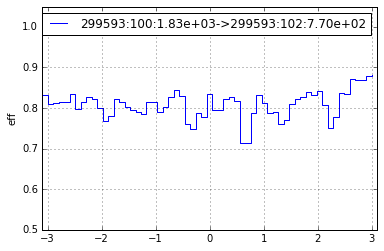

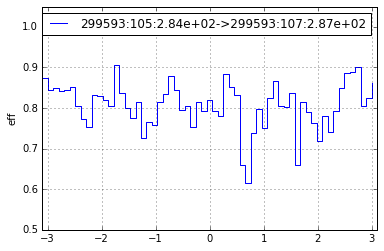

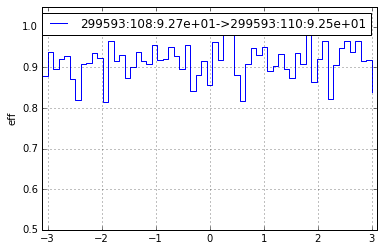

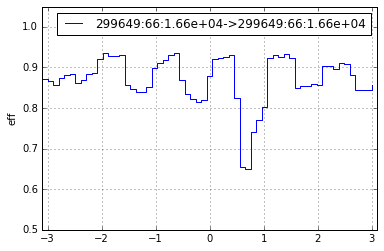

In [116]:
i=0
for b in bha :
    plt.step(b[0],b[1],where='post',label=runid0[i])
    plt.xlim(-3.1, 3.1)
    plt.ylim(0.5, 1.05)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.ylabel('eff')
    plt.show()
    i=i+1